In [ ]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display

from FewShotTestHandler import FewShotTestHandler
from dataset import DatasetHandler
from plotting_utils import plot

In [ ]:
params_dict = {}

# VLM Params - vlm.____ keys are passed into VLM constructor
from CLIP.CLIPVLM import ClipVLM as VLM
params_dict["vlm.num_frames"] = [1, 2, 3, 4, 10]

# Dataset Params - dataset.____ keys are passed into DatasetHandler constructor
params_dict["dataset.name"] = ["moma_act", "moma_sact", "kinetics_100"]
params_dict["dataset.split"] = ["test"]

# Classifier Params - classifier.____ keys are passed into classifier constructor
from classifier import WeightedTextFewShotClassifier as Classifier
params_dict["classifier.text_weight"] = [0, 0.1, 0.5, 1.0, 2.0, 4.0, 10.0, 20.0, 100.0]

# Few-Shot Test Params - test.____ keys are passed into few-shot test call
params_dict["test.n_way"] = [5, 10, 20]
params_dict["test.n_support"] = [0, 1, 5, 10, 20]
params_dict["test.n_query"] = [1]
params_dict["test.n_episodes"] = [1000]

In [ ]:
test_handler = FewShotTestHandler("temp.csv")

In [ ]:
vlm = None
cur_vlm_params = None
dataset = None
cur_dataset_params = None
cached_dataset_ids = set()

pbar = tqdm(list(itertools.product(*params_dict.values())))
for params in pbar:
    # Associate keys to each param
    params = dict(zip(params_dict.keys(), params))
    
    pbar.set_postfix(params)
    
    # vlm params
    vlm_params = {key[4:]: val for key, val in params.items() if key.startswith("vlm.")}
    classifier_params = {key[11:]: val for key, val in params.items() if key.startswith("classifier.")}
    dataset_params = {key[8:]: val for key, val in params.items() if key.startswith("dataset.")}
    test_params = {key[5:]: val for key, val in params.items() if key.startswith("test.")}
    
    if vlm is None or cur_vlm_params != vlm_params:
        vlm = VLM(**vlm_params)
        cur_vlm_params = vlm_params
        cached_dataset_ids = set()
        
    if dataset is None or cur_dataset_params != dataset_params:
        dataset = DatasetHandler(**dataset_params)
        cur_dataset_params = dataset_params
        
    if dataset.id() not in cached_dataset_ids:
        test_handler.fill_cache(vlm, dataset)
        cached_dataset_ids.add(dataset.id())
        
    if not dataset.valid_for_few_shot(test_params["n_way"], test_params["n_support"], test_params["n_query"]):
        continue
    
    # Ensure 0-shot tests always set classifier.text_weight to 1
    if test_params["n_support"] == 0 and "text_weight" in classifier_params:
        classifier_params["text_weight"] = 1.0
    
    classifier = Classifier(vlm, **classifier_params)
    test_handler.run_few_shot_test(classifier, dataset, **test_params)

### Plot Results

35 Overall Lines
7 Separate Plots


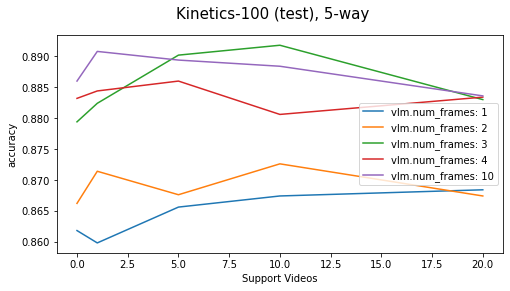

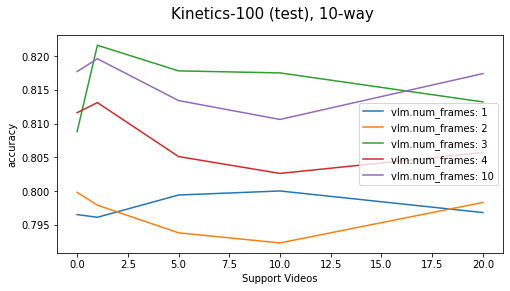

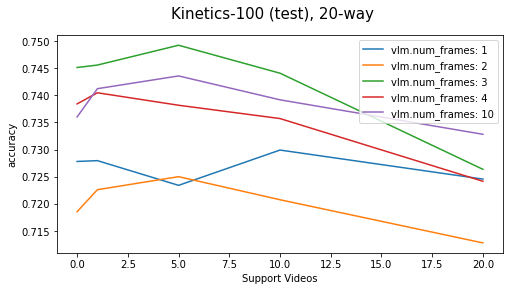

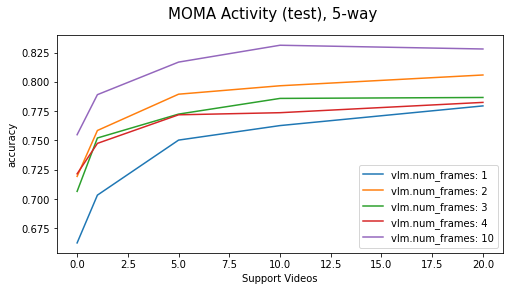

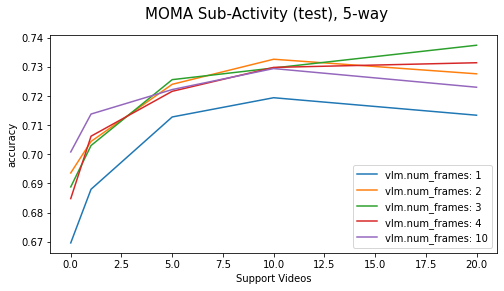

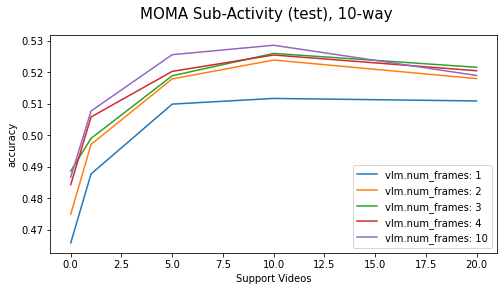

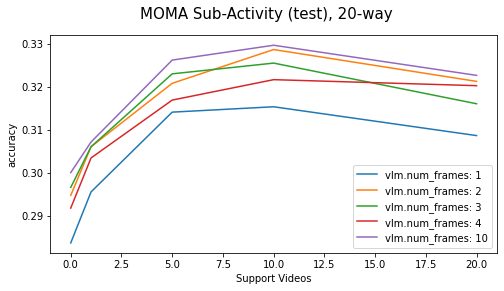

In [5]:
plot(
    test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["dataset", "n_way"],
    line_descriptor_cols=["vlm.num_frames"],
    agg_dict={
        "classifier.text_weight": max
    },
    filter_dict={}
)